In [13]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import re
from collections import Counter
import spacy
from kneed import KneeLocator
import matplotlib.pyplot as plt
import sys

# Ensure required NLTK resources are downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

class TextParserEvaluator:
    def __init__(self, use_spacy=True):
        self.stop_words = set(stopwords.words('english'))
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        self.use_spacy = use_spacy
        if use_spacy:
            try:
                self.nlp = spacy.load('en_core_web_sm')
            except:
                print("Spacy model not found. Installing 'en_core_web_sm'...")
                import subprocess
                subprocess.call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
                self.nlp = spacy.load('en_core_web_sm')
    
    def preprocess_text(self, text):
        """Clean and tokenize text."""
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
        text = text.lower()  # Convert to lowercase
        return text
    
    def determine_optimal_sentence_count(self, sentence_importance, max_sentences=50):
        """
        Algorithmically determine the optimal number of key sentences to extract
        using the elbow/knee method on the sentence importance scores.
        """
        # Sort importance scores in descending order
        sorted_scores = np.sort(sentence_importance)[::-1]
        
        # Limit to max_sentences to avoid processing very long documents entirely
        n = min(len(sorted_scores), max_sentences)
        sorted_scores = sorted_scores[:n]
        
        # If document is very short, return proportional number of sentences
        if len(sorted_scores) < 5:
            return max(1, len(sorted_scores) // 2)
        
        try:
            # Use KneeLocator to find the "elbow point" in the curve
            x = np.arange(1, len(sorted_scores) + 1)
            kneedle = KneeLocator(x, sorted_scores, S=1.0, curve="convex", direction="decreasing")
            knee_point = kneedle.knee
            
            if knee_point:
                return int(knee_point)
            else:
                # Fallback: use proportion of total sentences
                return max(3, min(int(len(sentence_importance) * 0.2), max_sentences))
        except:
            # Fallback method if KneeLocator fails or isn't available
            # Calculate differences between consecutive scores
            differences = np.diff(sorted_scores)
            
            # Find where the differences become small (rate of change slows down)
            threshold = np.mean(differences) * 0.5
            significant_indices = np.where(differences > threshold)[0]
            
            if len(significant_indices) > 0:
                # Get the index where importance starts to flatten
                elbow_index = significant_indices[-1] + 1
                return min(elbow_index + 1, n)
            else:
                # Default to proportion of document length
                return max(3, min(int(len(sentence_importance) * 0.2), max_sentences))
    
    def extract_key_sentences(self, document, max_sentences=50):
        """
        Extract the most important sentences from the document based on TF-IDF.
        The number of sentences is determined algorithmically.
        """
        sentences = sent_tokenize(document)
        
        # Handle very short documents
        if len(sentences) <= 3:
            return sentences
        
        # Calculate sentence importance
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(sentences)
        sentence_importance = np.sum(tfidf_matrix.toarray(), axis=1)
        
        # Determine optimal number of sentences to extract
        num_sentences = self.determine_optimal_sentence_count(sentence_importance, max_sentences)
        
        # Return the top sentences with their indices
        top_indices = sentence_importance.argsort()[-num_sentences:][::-1]
        return [sentences[i] for i in top_indices]
    
    def extract_entities(self, document):
        """Extract named entities from the document."""
        if not self.use_spacy:
            return []
        
        doc = self.nlp(document)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        print("Enitites:")
        print(entities)
        return entities
    
    def calculate_coverage(self, document, qa_pairs):
        """Calculate how much of the document's key information is covered by QA pairs."""
        # Extract key sentences and entities from the document
        key_sentences = self.extract_key_sentences(document)
        entities = self.extract_entities(document)
        entity_texts = [e[0].lower() for e in entities]
        
        # Combine Q and A for each pair
        qa_texts = [f"{q} {a}" for q, a in qa_pairs]
        
        # Calculate coverage of key sentences
        sentence_coverage = []
        for sentence in key_sentences:
            max_similarity = 0
            for qa_text in qa_texts:
                # Calculate similarity between sentence and QA pair
                docs = [sentence, qa_text]
                tfidf_matrix = self.tfidf_vectorizer.fit_transform(docs)
                similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
                max_similarity = max(max_similarity, similarity)
            sentence_coverage.append(max_similarity)
        
        # Calculate entity coverage
        entity_coverage = []
        for entity in entity_texts:
            is_covered = False
            for qa_text in qa_texts:
                if entity in qa_text.lower():
                    is_covered = True
                    break
            entity_coverage.append(1.0 if is_covered else 0.0)
        
        # Calculate content words coverage
        document_words = set(word for word in word_tokenize(document.lower()) 
                            if word.isalnum() and word not in self.stop_words)
        qa_words = set(word for qa_text in qa_texts 
                      for word in word_tokenize(qa_text.lower())
                      if word.isalnum() and word not in self.stop_words)
        
        word_coverage = len(document_words.intersection(qa_words)) / len(document_words) if document_words else 0
        
        return {
            'sentence_coverage': np.mean(sentence_coverage) if sentence_coverage else 0,
            'entity_coverage': np.mean(entity_coverage) if entity_coverage else 0,
            'word_coverage': word_coverage,
            'num_qa_pairs': len(qa_pairs),
            'doc_length': len(word_tokenize(document)),
            'qa_density': len(qa_pairs) / (len(sent_tokenize(document)) or 1),
            'key_sentences_extracted': len(key_sentences)
        }
    
    def evaluate_qa_quality(self, qa_pairs):
        """Evaluate the quality of QA pairs."""
        results = {
            'avg_question_length': np.mean([len(word_tokenize(q)) for q, _ in qa_pairs]) if qa_pairs else 0,
            'avg_answer_length': np.mean([len(word_tokenize(a)) for _, a in qa_pairs]) if qa_pairs else 0,
        }
        
        # Check if questions start with question words
        question_starters = ['what', 'where', 'when', 'who', 'why', 'how', 'which', 'can', 'do', 'does', 'is', 'are']
        starts_with_question_word = [any(q.lower().startswith(starter) for starter in question_starters) for q, _ in qa_pairs]
        
        results['proper_question_format'] = np.mean(starts_with_question_word) if starts_with_question_word else 0
        
        # Check if questions end with question mark
        ends_with_question_mark = [q.strip().endswith('?') for q, _ in qa_pairs]
        results['has_question_mark'] = np.mean(ends_with_question_mark) if ends_with_question_mark else 0
        
        return results
    
    def analyze_question_types(self, qa_pairs):
        """Analyze the types of questions in the QA pairs."""
        question_types = {
            'what': 0, 'where': 0, 'when': 0, 'who': 0, 
            'why': 0, 'how': 0, 'which': 0, 'other': 0
        }
        
        for q, _ in qa_pairs:
            q_lower = q.lower().strip()
            matched = False
            for q_type in question_types.keys():
                if q_type != 'other' and q_lower.startswith(q_type):
                    question_types[q_type] += 1
                    matched = True
                    break
            if not matched:
                question_types['other'] += 1
        
        # Convert counts to percentages
        total = sum(question_types.values())
        if total > 0:
            for q_type in question_types:
                question_types[q_type] = (question_types[q_type] / total) * 100
                
        return question_types
    
    def visualize_importance_curve(self, sentence_importance, knee_point=None):
        """Generate a visualization of sentence importance scores to show the elbow/knee point."""
        sorted_scores = np.sort(sentence_importance)[::-1]
        x = np.arange(1, len(sorted_scores) + 1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(x, sorted_scores, '-o', markersize=4)
        plt.title('Sentence Importance Distribution')
        plt.xlabel('Sentence Rank')
        plt.ylabel('Importance Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if knee_point:
            plt.axvline(x=knee_point, color='r', linestyle='--', 
                        label=f'Optimal Cut-off: {knee_point} sentences')
            plt.legend()
        
        plt.tight_layout()
        return plt
    
    def evaluate(self, document, qa_pairs, visualize=False):
        """Evaluate the QA pairs extracted from the document."""
        # Check input validity
        if not document or not isinstance(document, str):
            return {"error": "Invalid document: Document should be a non-empty string"}
        
        if not qa_pairs or not isinstance(qa_pairs, list):
            return {"error": "Invalid QA pairs: Should be a non-empty list of (question, answer) tuples"}
        
        # Preprocess document
        clean_document = self.preprocess_text(document)
        
        # Calculate coverage metrics
        coverage_metrics = self.calculate_coverage(clean_document, qa_pairs)
        
        # Evaluate QA quality
        quality_metrics = self.evaluate_qa_quality(qa_pairs)
        
        # Analyze question types
        question_type_analysis = self.analyze_question_types(qa_pairs)
        
        # Generate overall score (weighted average of metrics)
        overall_score = (
            coverage_metrics['sentence_coverage'] * 0.4 +
            coverage_metrics['entity_coverage'] * 0.3 +
            coverage_metrics['word_coverage'] * 0.2 +
            quality_metrics['proper_question_format'] * 0.05 +
            quality_metrics['has_question_mark'] * 0.05
        ) * 100  # Convert to percentage
        
        # Create full results
        evaluation_results = {
            'overall_score': overall_score,
            'coverage_metrics': coverage_metrics,
            'quality_metrics': quality_metrics,
            'question_type_analysis': question_type_analysis,
            'summary': {
                'total_qa_pairs': len(qa_pairs),
                'document_length_words': coverage_metrics['doc_length'],
                'qa_pairs_per_sentence': coverage_metrics['qa_density'],
                'key_sentences_used': coverage_metrics['key_sentences_extracted']
            }
        }
        
        # Generate visualization if requested
        if visualize:
            # We'd need to re-calculate sentence importance for visualization
            sentences = sent_tokenize(clean_document)
            tfidf_matrix = self.tfidf_vectorizer.fit_transform(sentences)
            sentence_importance = np.sum(tfidf_matrix.toarray(), axis=1)
            optimal_count = self.determine_optimal_sentence_count(sentence_importance)
            
            try:
                plot = self.visualize_importance_curve(sentence_importance, optimal_count)
                evaluation_results['visualization'] = plot
            except Exception as e:
                evaluation_results['visualization_error'] = str(e)
        
        return evaluation_results

# Example usage
def evaluate_text_parser(document, qa_pairs, visualize=False):
    evaluator = TextParserEvaluator()
    results = evaluator.evaluate(document, qa_pairs, visualize)
    
    # Format results for display
    print(f"===== Text Parser Evaluation Results =====")
    print(f"Overall Score: {results['overall_score']:.2f}%")
    print("\nCoverage Metrics:")
    print(f"  Key Sentence Coverage: {results['coverage_metrics']['sentence_coverage']:.2f}")
    print(f"  Entity Coverage: {results['coverage_metrics']['entity_coverage']:.2f}")
    print(f"  Word Coverage: {results['coverage_metrics']['word_coverage']:.2f}")
    print(f"  Key Sentences Extracted: {results['coverage_metrics']['key_sentences_extracted']}")
    
    print("\nQA Quality Metrics:")
    print(f"  Average Question Length: {results['quality_metrics']['avg_question_length']:.2f} words")
    print(f"  Average Answer Length: {results['quality_metrics']['avg_answer_length']:.2f} words")
    print(f"  Questions with Proper Format: {results['quality_metrics']['proper_question_format'] * 100:.2f}%")
    print(f"  Questions with Question Mark: {results['quality_metrics']['has_question_mark'] * 100:.2f}%")
    
    print("\nQuestion Type Distribution:")
    for q_type, percentage in results['question_type_analysis'].items():
        print(f"  {q_type.capitalize()}: {percentage:.2f}%")
    
    print("\nSummary:")
    print(f"  Total QA Pairs: {results['summary']['total_qa_pairs']}")
    print(f"  Document Length: {results['summary']['document_length_words']} words")
    print(f"  QA Pairs per Sentence: {results['summary']['qa_pairs_per_sentence']:.2f}")
    
    return results


In [ ]:
# Sample document
sample_document = """ James is an AI Engineer, and he likes to work on AI projects.
Artificial intelligence (AI) is intelligence demonstrated by machines, as opposed to natural intelligence displayed by animals including humans. 
AI research has been defined as the field of study of intelligent agents, which refers to any system that perceives its environment and takes actions that maximize its chance of achieving its goals.
The term "artificial intelligence" had previously been used to describe machines that mimic and display "human" cognitive skills that are associated with the human mind, such as "learning" and "problem-solving".
This definition has since been rejected by major AI researchers who now describe AI in terms of rationality and acting rationally, which does not limit how intelligence can be articulated.
AI applications include advanced web search engines, recommendation systems, understanding human speech, self-driving cars, automated decision-making and competing at the highest level in strategic game systems.
"""

# Sample QA pairs
sample_qa_pairs = [
    ("What does James do?", "James is an AI Engineer."),
    ("What is artificial intelligence?", "Intelligence demonstrated by machines, as opposed to natural intelligence displayed by animals including humans."),
    ("How is AI research defined?", "As the field of study of intelligent agents, which refers to any system that perceives its environment and takes actions that maximize its chance of achieving its goals."),
    ("What are some applications of AI?", "Advanced web search engines, recommendation systems, understanding human speech, self-driving cars, automated decision-making and competing at strategic games."),
    ("How do researchers now describe AI?", "In terms of rationality and acting rationally, which does not limit how intelligence can be articulated.")
]

# Evaluate
evaluate_text_parser(sample_document, sample_qa_pairs)


Enitites:
[('james', 'PERSON')]
===== Text Parser Evaluation Results =====
Overall Score: 90.14%

Coverage Metrics:
  Key Sentence Coverage: 0.90
  Entity Coverage: 1.00
  Word Coverage: 0.71
  Key Sentences Extracted: 2

QA Quality Metrics:
  Average Question Length: 6.00 words
  Average Answer Length: 18.60 words
  Questions with Proper Format: 100.00%
  Questions with Question Mark: 100.00%

Question Type Distribution:
  What: 60.00%
  Where: 0.00%
  When: 0.00%
  Who: 0.00%
  Why: 0.00%
  How: 40.00%
  Which: 0.00%
  Other: 0.00%

Summary:
  Total QA Pairs: 5
  Document Length: 175 words
  QA Pairs per Sentence: 0.83


{'overall_score': np.float64(90.1387042825819),
 'coverage_metrics': {'sentence_coverage': np.float64(0.8993009403978801),
  'entity_coverage': np.float64(1.0),
  'word_coverage': 0.7083333333333334,
  'num_qa_pairs': 5,
  'doc_length': 175,
  'qa_density': 0.8333333333333334,
  'key_sentences_extracted': 2},
 'quality_metrics': {'avg_question_length': np.float64(6.0),
  'avg_answer_length': np.float64(18.6),
  'proper_question_format': np.float64(1.0),
  'has_question_mark': np.float64(1.0)},
 'question_type_analysis': {'what': 60.0,
  'where': 0.0,
  'when': 0.0,
  'who': 0.0,
  'why': 0.0,
  'how': 40.0,
  'which': 0.0,
  'other': 0.0},
 'summary': {'total_qa_pairs': 5,
  'document_length_words': 175,
  'qa_pairs_per_sentence': 0.8333333333333334,
  'key_sentences_used': 2}}

Enitites:
[('james', 'PERSON')]
===== Text Parser Evaluation Results =====
Overall Score: 90.14%

Coverage Metrics:
  Key Sentence Coverage: 0.90
  Entity Coverage: 1.00
  Word Coverage: 0.71
  Key Sentences Extracted: 2

QA Quality Metrics:
  Average Question Length: 6.00 words
  Average Answer Length: 18.60 words
  Questions with Proper Format: 100.00%
  Questions with Question Mark: 100.00%

Question Type Distribution:
  What: 60.00%
  Where: 0.00%
  When: 0.00%
  Who: 0.00%
  Why: 0.00%
  How: 40.00%
  Which: 0.00%
  Other: 0.00%

Summary:
  Total QA Pairs: 5
  Document Length: 175 words
  QA Pairs per Sentence: 0.83


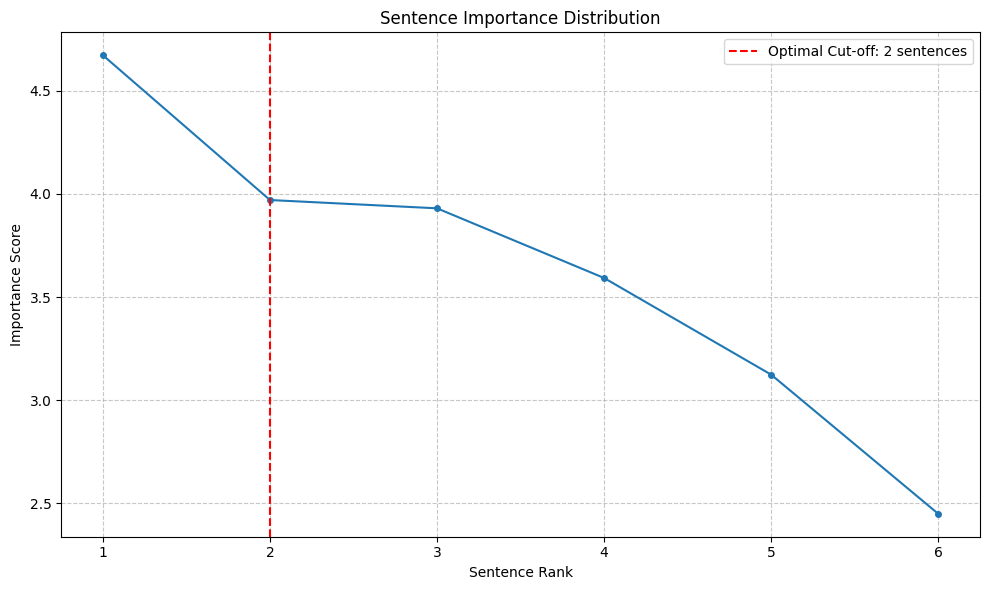

In [18]:
# Visualize the importance curve
evaluate_text_parser(sample_document, sample_qa_pairs, visualize=True)
plt.show()

In [10]:
from utils import pdf_to_text
pdf_url = "https://s3.ap-southeast-1.amazonaws.com/storage.distilled.ai/phuong/Cosmoverse+2024+-+Summary.pdf"
pdf_to_text(pdf_url,"./inputs/tu_document.txt")

Error when extract pdf: Error 524: <!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>


<title>data.distilled.ai | 524: A timeout occurred</title>
<meta charset="UTF-8" />
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta http-equiv="X-UA-Compatible" content="IE=Edge" />
<meta name="robots" content="noindex, nofollow" />
<meta name="viewport" content="width=device-width,initial-scale=1" />
<link rel="stylesheet" id="cf_styles-css" href="/cdn-cgi/styles/main.css" />


</head>
<body>
<div id="cf-wrapper">
    <div id="cf-error-details" class="p-0">
        <header class="mx-auto pt-10 lg:pt-6 lg:px-8 w-240 lg:w-full mb-8">
            <h1 class="inline-block sm:block sm:mb-2 font-light text-60 lg

False